** Importing liberies and frameworks **

In [67]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

**Load videos and Preprocessing : ** defines a function load_video that takes a path to a video file as input and returns a preprocessed version of the video frames as a list of TensorFlow tensors lets eplain this with a simple graphe *

Test the function (LOad_video)

In [68]:
def load_video(path:str) -> List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

In [69]:
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
value=load_video(path)
value

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4616871 ],
         [1.4616871 ],
         [1.4991663 ],
         ...,
         [0.3373124 ],
         [0.3373124 ],
         [0.3373124 ]],

        ...,

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.11243746],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.07495831],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.07495831],
         [0.07495831],
         [0.03747915]]],


  

**Extracts information from files, and compiles a vocabulary list**

In [70]:
#ADDITIONAL FUNCTION I MADE TO GET vocab WHICH IS A PARAMETER FOR THE CHAR_TO_NUM FUNCTION
def get_vocab():
    vocab=[]
    directory="/kaggle/input/lipreading/data/alignments/s1"
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            lines=f.readlines()
            for line in lines:
                line=line.split()
                vocab.append(line[2])
    return vocab       

In [71]:
vocab=np.unique(get_vocab())

In [72]:
print(vocab)

['a' 'again' 'at' 'b' 'bin' 'blue' 'by' 'c' 'd' 'e' 'eight' 'f' 'five'
 'four' 'g' 'green' 'h' 'i' 'in' 'j' 'k' 'l' 'lay' 'm' 'n' 'nine' 'now'
 'o' 'one' 'p' 'place' 'please' 'q' 'r' 'red' 's' 'set' 'seven' 'sil'
 'six' 'soon' 'sp' 't' 'three' 'two' 'u' 'v' 'white' 'with' 'x' 'y' 'z'
 'zero']


> Create a Mapping layers for preprocessing using tensorflow Stringlookup :tf.keras.layers.StringLookup

In [73]:
char_to_num= tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True)

> char_to_num StringLookup Layer:
> 
> tf.keras.layers.StringLookup is used to create a layer that maps characters to numerical indices.
> The vocabulary parameter is set to your vocab, which is the list of characters obtained from your get_vocab function.
> oov_token stands for "out-of-vocabulary" token and is set to an empty string (""). This token is used for unseen characters during inference.
> num_to_char StringLookup Layer:
> 
> Another StringLookup layer is created to map numerical indices back to characters.
> The vocabulary parameter is set to the vocabulary obtained from the char_to_num layer using char_to_num.get_vocabulary().
> oov_token is also set to an empty string (""), and invert is set to True, indicating that this layer should perform an inverse mapping.

> *After convert the alignments to a num (Conversion to Numerical Indices) ---> reshape the tensor to one dim tensor*

In [74]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines=f.readlines()
        
            
        
    tokens=[]
    for line in lines:
        line=line.split()
        if line[2]!= 'sil':
            tokens= [*tokens,' ',line[2]]
        
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [75]:
path="/kaggle/input/lipreading/data/alignments/s1/bbaf2n.align"
load_alignments(path)


<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 4, 18, 25,  0,  4, 22, 46, 10,  0,  1, 43,  0, 12,  0, 43,  0, 28,
        0, 25, 28,  0])>

In [76]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split('/')[-1].split('.')[0]
    video_path=os.path.join('/kaggle/input/lipreading/data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('/kaggle/input/lipreading/data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    
    return frames,alignments

In [77]:
#TESTING THE OUTPUT FOR A SAMPLE FILE
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
frames, alignments=load_data(tf.convert_to_tensor(path))
print("frames:",frames)
print("alignments:",alignments)

frames: tf.Tensor(
[[[[1.4991663 ]
   [1.4991663 ]
   [1.4616871 ]
   ...
   [0.41227072]
   [0.41227072]
   [0.41227072]]

  [[1.4991663 ]
   [1.4991663 ]
   [1.4616871 ]
   ...
   [0.41227072]
   [0.41227072]
   [0.41227072]]

  [[1.4616871 ]
   [1.4616871 ]
   [1.4991663 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  ...

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.11243746]
   [0.11243746]
   [0.07495831]]

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.11243746]
   [0.07495831]
   [0.07495831]]

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.07495831]
   [0.07495831]
   [0.03747915]]]


 [[[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  [[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  [[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.29983324]
   [0.29983324]
   [0.29983324]]

  ...

  [[1.0494163 ]
   [

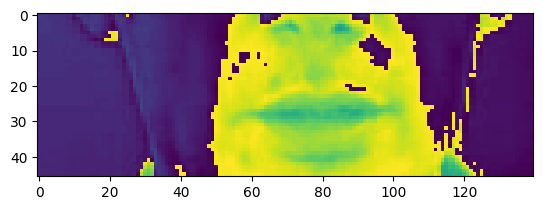

In [78]:
plt.imshow(frames[15])

**
Sets up a TensorFlow data pipeline for loading lipreading data from video file**

In [79]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [80]:
data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# # ADDED DOR SPLIT
train = data.take(450)
test = data.skip(450)

In [81]:
frames, alighnments = data.as_numpy_iterator().next()

In [82]:
sample = data.as_numpy_iterator()

In [83]:
val = sample.next();val[0]

array([[[[[1.4024913 ],
          [1.4024913 ],
          [1.3655837 ],
          ...,
          [0.29526132],
          [0.29526132],
          [0.29526132]],

         [[1.4024913 ],
          [1.4024913 ],
          [1.3655837 ],
          ...,
          [0.29526132],
          [0.29526132],
          [0.29526132]],

         [[1.4763066 ],
          [1.4763066 ],
          [1.4024913 ],
          ...,
          [0.4059843 ],
          [0.36907664],
          [0.36907664]],

         ...,

         [[1.10723   ],
          [1.0703223 ],
          [1.0703223 ],
          ...,
          [0.07381533],
          [0.03690767],
          [0.03690767]],

         [[1.0334146 ],
          [1.0334146 ],
          [1.0334146 ],
          ...,
          [0.07381533],
          [0.03690767],
          [0.03690767]],

         [[1.0334146 ],
          [1.0334146 ],
          [1.0334146 ],
          ...,
          [0.07381533],
          [0.03690767],
          [0.        ]]],


        [[[1.5132

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D,Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [85]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [86]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [87]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_6 (Activation)   (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_7 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_7 (Activation)   (None, 75, 23, 70, 256)   0         
                                                      

In [88]:
yhat = model.predict(val[0])

1/1 [==============================] - 2s 2s/step


In [89]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [90]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [91]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [95]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [97]:
history = model.fit(train, validation_data=test, epochs=20, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/20
  1/450 [..............................] - ETA: 8:19 - loss: 109.4830

[mpeg1video @ 0x7f96ec8dd040] ac-tex damaged at 22 17
[mpeg1video @ 0x7f96ec8dd040] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 82.5556

[mpeg1video @ 0x7f9b7005b3c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b7005b3c0] Warning MVs not available
[mpeg1video @ 0x7f9b687bd140] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b687bd140] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Original: laygreenithmsevensoon
Prediction: leeeee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layblueatyzeroplease
Prediction: leeee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 900s 2s/step - loss: 82.5556 - val_loss: 70.8263 - lr: 1.0000e-04
Epoch 2/20
237/450 [==============>...............] - ETA: 3:28 - loss: 72.4330

[mpeg1video @ 0x7f9b20a57240] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b20a57240] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 71.3913

[mpeg1video @ 0x7f9b840b0b40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b840b0b40] Warning MVs not available


1/1 [==============================] - 0s 208ms/step
Original: setredbybfivesoon
Prediction: leeeeee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layhiteatltono
Prediction: leeeeee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 679s 2s/step - loss: 71.3913 - val_loss: 66.0575 - lr: 1.0000e-04
Epoch 3/20
 61/450 [===>..........................] - ETA: 6:18 - loss: 69.7686

[mpeg1video @ 0x7f9788013180] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9788013180] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 67.9184

[mpeg1video @ 0x7f9b30028ec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b30028ec0] Warning MVs not available


1/1 [==============================] - 0s 209ms/step
Original: placegreenindsevenagain
Prediction: laeeeeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placeredinpthreeagain
Prediction: laeeeeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 677s 2s/step - loss: 67.9184 - val_loss: 62.1298 - lr: 1.0000e-04
Epoch 4/20
234/450 [==============>...............] - ETA: 3:29 - loss: 65.7381

[mpeg1video @ 0x7f9ce8013a80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9ce8013a80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 64.8301

[mpeg1video @ 0x7f9b20a59e40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b20a59e40] Warning MVs not available


1/1 [==============================] - 0s 206ms/step
Original: bingreenataeightplease
Prediction: laeeteo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bingreenithbfivesoon
Prediction: laeeeeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 678s 2s/step - loss: 64.8301 - val_loss: 60.9308 - lr: 1.0000e-04
Epoch 5/20
  3/450 [..............................] - ETA: 7:17 - loss: 66.1448

[mpeg1video @ 0x7f9b9403be80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b9403be80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 62.7211

[mpeg1video @ 0x5759f93caa80] ac-tex damaged at 22 17
[mpeg1video @ 0x5759f93caa80] Warning MVs not available


1/1 [==============================] - 0s 211ms/step
Original: layhiteinloneagain
Prediction: laeteea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setblueithufivesoon
Prediction: laeteeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 669s 1s/step - loss: 62.7211 - val_loss: 58.9744 - lr: 1.0000e-04
Epoch 6/20
358/450 [======================>.......] - ETA: 1:27 - loss: 59.8507

[mpeg1video @ 0x7f9b6899bb80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b6899bb80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 59.3524

[mpeg1video @ 0x7f9c30041200] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9c30041200] Warning MVs not available


1/1 [==============================] - 0s 207ms/step
Original: binblueinrsixno
Prediction: laetee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: laygreeninzthreesoon
Prediction: laretee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 662s 1s/step - loss: 59.3524 - val_loss: 53.7416 - lr: 1.0000e-04
Epoch 7/20
450/450 [==============================] - ETA: 0s - loss: 56.2781

[mpeg1video @ 0x7f9b84043500] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b84043500] Warning MVs not available


1/1 [==============================] - 0s 206ms/step
Original: binredinmzeroplease
Prediction: laretee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredithathreesoon
Prediction: lareeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 667s 1s/step - loss: 56.2781 - val_loss: 52.9933 - lr: 1.0000e-04
Epoch 8/20
449/450 [============================>.] - ETA: 0s - loss: 54.1999

[mpeg1video @ 0x7f9784032140] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9784032140] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 54.2079

[mpeg1video @ 0x7f9b34071280] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b34071280] Warning MVs not available


1/1 [==============================] - 0s 224ms/step
Original: layhitespbyfthreesoon
Prediction: lareteea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binbluebymzerono
Prediction: laretee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 662s 1s/step - loss: 54.2079 - val_loss: 50.3383 - lr: 1.0000e-04
Epoch 9/20
289/450 [==================>...........] - ETA: 2:31 - loss: 53.0071

[mpeg1video @ 0x7f9cd806b840] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9cd806b840] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 52.8304

[mpeg1video @ 0x7f978000c240] ac-tex damaged at 22 17
[mpeg1video @ 0x7f978000c240] Warning MVs not available


1/1 [==============================] - 0s 211ms/step
Original: binredinmoneagain
Prediction: lareieeae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bingreeninnonesoon
Prediction: lareieea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 654s 1s/step - loss: 52.8304 - val_loss: 48.7979 - lr: 1.0000e-04
Epoch 10/20
163/450 [=========>....................] - ETA: 4:30 - loss: 50.7572

[mpeg1video @ 0x7f9b90094b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b90094b80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 50.5006

[mpeg1video @ 0x7f9cec02d240] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9cec02d240] Warning MVs not available


1/1 [==============================] - 0s 211ms/step
Original: placeblueatpzeroplease
Prediction: larebeplase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binhitespbynfourplease
Prediction: lareteeae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 654s 1s/step - loss: 50.5006 - val_loss: 46.8577 - lr: 1.0000e-04
Epoch 11/20
298/450 [==================>...........] - ETA: 2:22 - loss: 48.7157

[mpeg1video @ 0x7f9b380ada00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b380ada00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 48.2811

[mpeg1video @ 0x7f9b9406b740] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b9406b740] Warning MVs not available


1/1 [==============================] - 0s 205ms/step
Original: setredinanineagain
Prediction: leareiieaon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setblueattsixno
Prediction: lareitno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 652s 1s/step - loss: 48.2811 - val_loss: 42.8308 - lr: 1.0000e-04
Epoch 12/20
315/450 [====================>.........] - ETA: 2:07 - loss: 46.2819

[mpeg1video @ 0x7f9b100ae280] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b100ae280] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 45.8843

[mpeg1video @ 0x7f9b8811a580] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b8811a580] Warning MVs not available


1/1 [==============================] - 0s 206ms/step
Original: sethiteatbsixno
Prediction: lareyoo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: laygreenbymfiveagain
Prediction: lacreeeae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 653s 1s/step - loss: 45.8843 - val_loss: 41.3384 - lr: 1.0000e-04
Epoch 13/20
409/450 [==========================>...] - ETA: 38s - loss: 43.1758

[mpeg1video @ 0x7f9cf007fb00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9cf007fb00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 43.3050

[mpeg1video @ 0x7f9b20c96d80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b20c96d80] Warning MVs not available


1/1 [==============================] - 0s 203ms/step
Original: laygreenatstono
Prediction: laretoo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: laygreenithgthreesoon
Prediction: searetoon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 655s 1s/step - loss: 43.3050 - val_loss: 38.4595 - lr: 1.0000e-04
Epoch 14/20
450/450 [==============================] - ETA: 0s - loss: 41.1111

[mpeg1video @ 0x7f9788088000] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9788088000] Warning MVs not available


1/1 [==============================] - 0s 204ms/step
Original: placehitebydnineagain
Prediction: placrebyieain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: laygreeninztono
Prediction: senreio
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 655s 1s/step - loss: 41.1111 - val_loss: 35.7269 - lr: 1.0000e-04
Epoch 15/20
243/450 [===============>..............] - ETA: 3:14 - loss: 38.6637

[mpeg1video @ 0x7f9b8404b640] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b8404b640] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 38.2696

[mpeg1video @ 0x7f9ce4023040] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9ce4023040] Warning MVs not available


1/1 [==============================] - 0s 204ms/step
Original: placegreeninkzeroplease
Prediction: placreioplase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setblueatasevenagain
Prediction: setblueiieain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 653s 1s/step - loss: 38.2696 - val_loss: 33.1808 - lr: 1.0000e-04
Epoch 16/20


[mpeg1video @ 0x7f9b34034980] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b34034980] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 35.9619

[mpeg1video @ 0x7f9b94040f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b94040f00] Warning MVs not available


1/1 [==============================] - 0s 206ms/step
Original: layhiteatzzerono
Prediction: layreitino
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setgreeninithreesoon
Prediction: sinreieson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 655s 1s/step - loss: 35.9619 - val_loss: 31.0404 - lr: 1.0000e-04
Epoch 17/20
116/450 [======>.......................] - ETA: 5:15 - loss: 34.6184

[mpeg1video @ 0x7f9b100251c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b100251c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 34.0597

[mpeg1video @ 0x7f9b689b5500] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b689b5500] Warning MVs not available


1/1 [==============================] - 0s 207ms/step
Original: bingreenithhninesoon
Prediction: bingreitieson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placegreenithrsevenagain
Prediction: placeretieagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 680s 2s/step - loss: 34.0597 - val_loss: 28.9835 - lr: 1.0000e-04
Epoch 18/20
 96/450 [=====>........................] - ETA: 5:35 - loss: 33.2123

[mpeg1video @ 0x7f9cec0bdc80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9cec0bdc80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 32.0484

[mpeg1video @ 0x7f9b1c069e00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b1c069e00] Warning MVs not available


1/1 [==============================] - 0s 204ms/step
Original: laybluebyythreesoon
Prediction: laybluebyeson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binblueinlthreesoon
Prediction: biyblueineon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 658s 1s/step - loss: 32.0484 - val_loss: 27.5970 - lr: 1.0000e-04
Epoch 19/20
169/450 [==========>...................] - ETA: 4:25 - loss: 30.0091

[mpeg1video @ 0x7f9b9400b480] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b9400b480] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 30.0661

[mpeg1video @ 0x7f9cfc0f8c40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9cfc0f8c40] Warning MVs not available


1/1 [==============================] - 0s 209ms/step
Original: layredithszeroplease
Prediction: liyreitoplese
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layredbyrsixplease
Prediction: bayrebyrxplese
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 656s 1s/step - loss: 30.0661 - val_loss: 24.1851 - lr: 1.0000e-04
Epoch 20/20
348/450 [======================>.......] - ETA: 1:36 - loss: 28.3877

[mpeg1video @ 0x7f9b7c047e40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9b7c047e40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 28.3661

[mpeg1video @ 0x7f9ce003ad40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9ce003ad40] Warning MVs not available


1/1 [==============================] - 0s 205ms/step
Original: placehiteinxtoplease
Prediction: placereitoplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layredatksevensoon
Prediction: bayreateveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 657s 1s/step - loss: 28.3661 - val_loss: 22.5240 - lr: 1.0000e-04


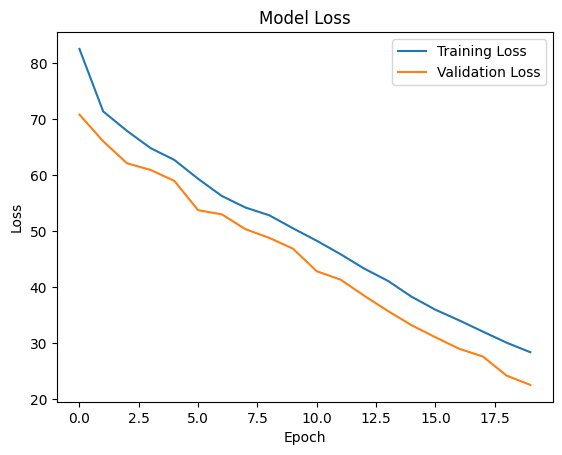

In [98]:


# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [101]:
# Save the model in the native Keras format
from tensorflow.keras.models import save_model
save_model(model, 'models/my_model.keras')
